In [1]:
import darwinian_shift
import pandas as pd
from darwinian_shift import DarwinianShift
import seaborn as sns
import matplotlib.pyplot as plt
from darwinian_shift import BinomTest
from darwinian_shift import MonteCarloTest
from darwinian_shift import CDFMonteCarloTest
from darwinian_shift import StructureDistanceLookup

import numpy as np
import matplotlib

/Users/davidshorthouse/anaconda3/envs/dsenv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/davidshorthouse/anaconda3/envs/dsenv/lib/python3.8/site-packages/MDAnalysis/coordinates/TRJ.py:1209: DeprecationWarning: Please use `netcdf_file` from the `scipy.io` namespace, the `scipy.io.netcdf` namespace is deprecated.
  class NCDFPicklable(scipy.io.netcdf.netcdf_file):


In [2]:
## We slightly hack darwinian_shift in order to plot nice looking figures

def plot_boxplot2(self, spectra=None, plot_scale=None, show_plot=False, colours=None,
                     figsize=(5, 5), return_fig=False, ax=None):
        """
        Boxplot of the expected and observed distributions of mutation scores.
        :param spectra: The mutational spectrum or list of mutational spectra to use.
        :param plot_scale:  Scale for the y-axis (mutation scores). Passed to matplotlib. 'log', 'symlog' etc.
        :param show_plot: If True, will call plt.show().
        :param colours: List of colours. First colour is for the observed data, the subsequent colours are
        for plotting the null distributions from each of the mutational spectra given.
        :param figsize: Size of the figure.
        :param return_fig: If True, will return the figure. Used for testing.
        :param ax: Matplotlib axis to plot on. If None, will create a new figure.
        :return: By default, None. If return_fig=True, will return the figure.
        """
#        if ax is None:
#            fig, ax = plt.subplots(figsize=figsize)
#        else:
#            fig = ax.figure

        spectra = self._get_spectra(spectra)

        colours = self._get_plot_colours(colours, len(spectra)+1)
        data = [get_distribution_from_mutational_spectrum(self.null_scores,
                                                          self.null_mutations[spectrum.rate_column])
                for spectrum in spectra]
        data.append(self.observed_values)
        
        return(data)
    
    
def get_distribution_from_mutational_spectrum(values, mut_rates, num=1000000):
    mut_rates = np.array(mut_rates)
    weights = mut_rates / mut_rates.sum()
    dist = np.repeat(values, np.random.multinomial(num, weights))
    return dist

In [3]:
## Read in our mutational data
CROSS_mutation_data = pd.read_csv("../CROSS_mutations.csv")
FLOT_mutation_data = pd.read_csv("../FLOT_mutations.csv")
NT_mutation_data = pd.read_csv("../NT_mutations.csv")

In [4]:
## Define our gene and an appropriate pdb file
ATM_gene = {
    'gene': 'ATM',
    'pdb_id': '7SIC', 
    'pdb_chain': 'A'
}

In [5]:
## We generate our mutational signatures - note this may take a while to calculate
d_cross = DarwinianShift(
    data = pd.read_csv("../CROSS_mutations.csv"),
    source_genome = "GRCh37",
    included_mutation_types = "missense")


d_flot = DarwinianShift(
    data = pd.read_csv("../FLOT_mutations.csv"),
    source_genome = "GRCh37",
    included_mutation_types = "missense")



d_nt = DarwinianShift(
    data = pd.read_csv("../NT_mutations.csv"),
    source_genome = "GRCh37",
    included_mutation_types = "missense")



## Compare to known LoF mutations

In [6]:
## Read in and generate known LoF mutation file 
## Taken from: Yamamoto et al:  https://doi.org/10.7554/eLife.14709
known_LoF = pd.read_excel("./Known_LoF_mutations/elife-14709-supp1.xlsx"
                          , sheet_name="Supplementary Information 1B")

known_LoF.columns = known_LoF.iloc[0]
known_LoF_missense = known_LoF[known_LoF["Mutation_Type"] == "Missense_Mutation"]

known_LoF_missense_mutations = list(set(known_LoF_missense["Protein_Change"].tolist()))

print(len(known_LoF_missense_mutations))

190


### CROSS

In [7]:
from darwinian_shift import VariantMatchLookup

vm_lookup = VariantMatchLookup(match_column='aachange', target_key="match_list")

v_cross = d_cross.run_section({
        'gene': 'ATM',
        'lookup': vm_lookup,
        'match_list': known_LoF_missense_mutations}
        ,statistics=BinomTest()
        )

In [8]:
v_cross.get_results_dictionary()

{'gene': 'ATM',
 'transcript_id': 'ENST00000452508',
 'chrom': '11',
 'section_id': 'ENST00000452508',
 'num_mutations': 51,
 'observed_median': 0.0,
 'observed_mean': 0.0392156862745098,
 'expected_median_glob_k3': 0.0,
 'median_shift_glob_k3': 0.0,
 'expected_mean_glob_k3': 0.01890392221000559,
 'mean_shift_glob_k3': 0.020311764064504214,
 'binom_glob_k3_pvalue': 0.2508990159766516,
 'binom_glob_k3_expected_proportion': 0.01890392221000559,
 'binom_glob_k3_observed_proportion': 0.0392156862745098,
 'binom_glob_k3_expected_count': 0.9641000327102851,
 'binom_glob_k3_observed_count': 2,
 'binom_glob_k3_threshold': 0.5,
 'binom_glob_k3_expected_CI_high': 3.0,
 'binom_glob_k3_expected_CI_low': 0.0,
 'binom_glob_k3_observed_CI_low': 0.0,
 'binom_glob_k3_observed_CI_high': 5.0}

### FLOT

In [9]:
vm_lookup = VariantMatchLookup(match_column='aachange', target_key="match_list")

v_flot = d_flot.run_section({
        'gene': 'ATM',
        'lookup': vm_lookup,
        'match_list': known_LoF_missense_mutations}
        ,statistics=BinomTest()
        )

In [10]:
v_flot.get_results_dictionary()

{'gene': 'ATM',
 'transcript_id': 'ENST00000452508',
 'chrom': '11',
 'section_id': 'ENST00000452508',
 'num_mutations': 36,
 'observed_median': 0.0,
 'observed_mean': 0.05555555555555555,
 'expected_median_glob_k3': 0.0,
 'median_shift_glob_k3': 0.0,
 'expected_mean_glob_k3': 0.01976679214055844,
 'mean_shift_glob_k3': 0.03578876341499711,
 'binom_glob_k3_pvalue': 0.15882162726808252,
 'binom_glob_k3_expected_proportion': 0.01976679214055844,
 'binom_glob_k3_observed_proportion': 0.05555555555555555,
 'binom_glob_k3_expected_count': 0.7116045170601039,
 'binom_glob_k3_observed_count': 2,
 'binom_glob_k3_threshold': 0.5,
 'binom_glob_k3_expected_CI_high': 3.0,
 'binom_glob_k3_expected_CI_low': 0.0,
 'binom_glob_k3_observed_CI_low': 0.0,
 'binom_glob_k3_observed_CI_high': 5.0}

### NT

In [11]:
vm_lookup = VariantMatchLookup(match_column='aachange', target_key="match_list")

v_nt = d_nt.run_section({
        'gene': 'ATM',
        'lookup': vm_lookup,
        'match_list': known_LoF_missense_mutations}
        ,statistics=BinomTest()
        )

In [12]:
v_nt.get_results_dictionary()

{'gene': 'ATM',
 'transcript_id': 'ENST00000452508',
 'chrom': '11',
 'section_id': 'ENST00000452508',
 'num_mutations': 33,
 'observed_median': 0.0,
 'observed_mean': 0.18181818181818182,
 'expected_median_glob_k3': 0.0,
 'median_shift_glob_k3': 0.0,
 'expected_mean_glob_k3': 0.02077075838693494,
 'mean_shift_glob_k3': 0.1610474234312469,
 'binom_glob_k3_pvalue': 5.4892594875455796e-05,
 'binom_glob_k3_expected_proportion': 0.02077075838693494,
 'binom_glob_k3_observed_proportion': 0.18181818181818182,
 'binom_glob_k3_expected_count': 0.685435026768853,
 'binom_glob_k3_observed_count': 6,
 'binom_glob_k3_threshold': 0.5,
 'binom_glob_k3_expected_CI_high': 3.0,
 'binom_glob_k3_expected_CI_low': 0.0,
 'binom_glob_k3_observed_CI_low': 2.0,
 'binom_glob_k3_observed_CI_high': 11.0}

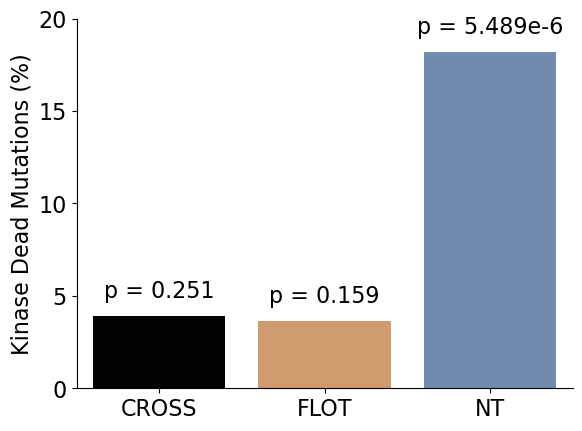

In [13]:
fig, ax = plt.subplots()
sample = [0,1,2]
binomial_test = [0.146, 4, 0.160, 12, 0.154, 4]

ratio = [2/51, 2/55, 6/33]


g = sns.barplot(x = sample, y = ratio, palette= ["k", "#E0995E", "#668AB8"], ax = ax)
g.set_xticklabels(["CROSS", "FLOT", "NT"], size = 16)
g.set_ylim(0,0.2)
g.set_yticks([0,0.050,0.1,0.15,0.2])
g.set_yticklabels([0,5,10,15,20], size = 16)
g.set_ylabel("Kinase Dead Mutations (%)", size = 16)  
    
sns.despine()

ax.annotate("p = 0.251", (0, 2/51+0.01), ha = "center", size = 16)
ax.annotate("p = 0.159", (1, 2/55+0.01), ha = "center", size = 16)
ax.annotate("p = 5.489e-6", (2, 6/33+0.01), ha = "center", size = 16)

plt.savefig("ATM_LoF_overlap.pdf", bbox_inches = "tight")

## Distance to kinase domain

In [14]:
## Define the kinase domain and the lookup
kinasedomain = "chainID A and resid 2614 to 3026"

kinasedist = StructureDistanceLookup(target_key = "target_selection", distance_to_alpha_carbons=True,
                                 sifts_directory = ".", pdb_directory=".", download_sifts=True)

ATM_dist = {
    "gene": "ATM",
    "pdb_id": "7SIC",
    "pdb_chain": "A",
    "target_selection":kinasedomain}

In [15]:
ATM_dist

{'gene': 'ATM',
 'pdb_id': '7SIC',
 'pdb_chain': 'A',
 'target_selection': 'chainID A and resid 2614 to 3026'}

### CROSS

In [16]:
s_cross = d_cross.run_section(ATM_dist, lookup=kinasedist, statistics = [MonteCarloTest(stat_function=np.mean, name = "MC_Mean"),
                                                                     MonteCarloTest(stat_function=np.median, name = "MC_Median"),
                                                                     CDFMonteCarloTest()])

/Users/davidshorthouse/anaconda3/envs/dsenv/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:429: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"


In [17]:
s_cross.get_results_dictionary()

{'gene': 'ATM',
 'transcript_id': 'ENST00000452508',
 'chrom': '11',
 'section_id': '7SIC:A',
 'num_mutations': 50,
 'observed_median': 24.72010303376831,
 'observed_mean': 35.529719674702314,
 'expected_median_glob_k3': 36.032865261228935,
 'median_shift_glob_k3': -11.312762227460624,
 'expected_mean_glob_k3': 44.09182703137533,
 'mean_shift_glob_k3': -8.562107356673017,
 'MC_Mean_glob_k3_observed': 35.529719674702314,
 'MC_Mean_glob_k3_null_mean': 44.03881308329059,
 'MC_Mean_glob_k3_null_median': 44.037159187260166,
 'MC_Mean_glob_k3_pvalue': 0.08199180081991801,
 'MC_Mean_glob_k3_num_smaller_or_equal': 410,
 'MC_Mean_glob_k3_num_larger_or_equal': 9592,
 'MC_Median_glob_k3_observed': 24.72010303376831,
 'MC_Median_glob_k3_null_mean': 38.37820751446242,
 'MC_Median_glob_k3_null_median': 36.2561968259113,
 'MC_Median_glob_k3_pvalue': 0.11578842115788421,
 'MC_Median_glob_k3_num_smaller_or_equal': 579,
 'MC_Median_glob_k3_num_larger_or_equal': 9423,
 'CDF_MC_glob_k3_num_smaller_or_equa

### FLOT

In [18]:
s_flot = d_flot.run_section(ATM_dist, lookup=kinasedist, statistics = [MonteCarloTest(stat_function=np.mean, name = "MC_Mean"),
                                                                     MonteCarloTest(stat_function=np.median, name = "MC_Median"),
                                                                     CDFMonteCarloTest()])
s_flot.get_results_dictionary()

/Users/davidshorthouse/anaconda3/envs/dsenv/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:429: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"


{'gene': 'ATM',
 'transcript_id': 'ENST00000452508',
 'chrom': '11',
 'section_id': '7SIC:A',
 'num_mutations': 33,
 'observed_median': 12.081364267767421,
 'observed_mean': 29.894609855155295,
 'expected_median_glob_k3': 35.849006809176295,
 'median_shift_glob_k3': -23.767642541408875,
 'expected_mean_glob_k3': 44.069624098901926,
 'mean_shift_glob_k3': -14.17501424374663,
 'MC_Mean_glob_k3_observed': 29.894609855155295,
 'MC_Mean_glob_k3_null_mean': 44.086503103850546,
 'MC_Mean_glob_k3_null_median': 43.91316104732449,
 'MC_Mean_glob_k3_pvalue': 0.015998400159984,
 'MC_Mean_glob_k3_num_smaller_or_equal': 80,
 'MC_Mean_glob_k3_num_larger_or_equal': 9922,
 'MC_Median_glob_k3_observed': 12.081364267767421,
 'MC_Median_glob_k3_null_mean': 38.83041719995586,
 'MC_Median_glob_k3_null_median': 36.007222249304256,
 'MC_Median_glob_k3_pvalue': 0.001999800019998,
 'MC_Median_glob_k3_num_smaller_or_equal': 10,
 'MC_Median_glob_k3_num_larger_or_equal': 9992,
 'CDF_MC_glob_k3_num_smaller_or_equal

### NT

In [19]:
s_nt = d_nt.run_section(ATM_dist, lookup=kinasedist, statistics = [MonteCarloTest(stat_function=np.mean, name = "MC_Mean"),
                                                                     MonteCarloTest(stat_function=np.median, name = "MC_Median"),
                                                                     CDFMonteCarloTest()])
s_nt.get_results_dictionary()

/Users/davidshorthouse/anaconda3/envs/dsenv/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:429: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"


{'gene': 'ATM',
 'transcript_id': 'ENST00000452508',
 'chrom': '11',
 'section_id': '7SIC:A',
 'num_mutations': 31,
 'observed_median': 5.721462493253744,
 'observed_mean': 21.661866279924315,
 'expected_median_glob_k3': 35.97229931398942,
 'median_shift_glob_k3': -30.25083682073567,
 'expected_mean_glob_k3': 44.077788580970605,
 'mean_shift_glob_k3': -22.41592230104629,
 'MC_Mean_glob_k3_observed': 21.661866279924315,
 'MC_Mean_glob_k3_null_mean': 44.134526712570924,
 'MC_Mean_glob_k3_null_median': 43.999056745146376,
 'MC_Mean_glob_k3_pvalue': 0.00039996000399960006,
 'MC_Mean_glob_k3_num_smaller_or_equal': 2,
 'MC_Mean_glob_k3_num_larger_or_equal': 10000,
 'MC_Median_glob_k3_observed': 5.721462493253744,
 'MC_Median_glob_k3_null_mean': 38.81185748381312,
 'MC_Median_glob_k3_null_median': 36.007222249304256,
 'MC_Median_glob_k3_pvalue': 0.00019998000199980003,
 'MC_Median_glob_k3_num_smaller_or_equal': 1,
 'MC_Median_glob_k3_num_larger_or_equal': 10001,
 'CDF_MC_glob_k3_num_smaller_o

### Plotting

In [20]:
### Not the best way to do it - but a way of combining all the boxplots from darwinian shift
data_cross = plot_boxplot2(s_cross)
data_flot = plot_boxplot2(s_flot)
data_nt= plot_boxplot2(s_nt)

basedistcross = data_cross[0]
crossdist = data_cross[1]
basedistflot = data_flot[0]
flotdist = data_flot[1]
basedistnt = data_flot[0]
ntdist = data_nt[1]

basedistcross = pd.DataFrame(basedistcross)
basedistcross["label"] = "base_cross"
basedistcross.columns = ["score", "label"]

basedistflot = pd.DataFrame(basedistflot)
basedistflot["label"] = "base_flot"
basedistflot.columns = ["score", "label"]

basedistnt = pd.DataFrame(basedistnt)
basedistnt["label"] = "base_nt"
basedistnt.columns = ["score", "label"]

crossdist = pd.DataFrame(crossdist)
crossdist["label"] = "cross"

flotdist = pd.DataFrame(flotdist)
flotdist["label"] = "flot"

ntdist = pd.DataFrame(ntdist)
ntdist["label"] = "nt"

testdist_cross = pd.DataFrame([-15])
testdist_cross["label"] = "base_cross"
testdist_cross.columns = ["score", "label"]

testdist_flot = pd.DataFrame([-15])
testdist_flot["label"] = "base_flot"
testdist_flot.columns = ["score", "label"]

testdist_nt = pd.DataFrame([-15])
testdist_nt["label"] = "base_nt"
testdist_nt.columns = ["score", "label"]

combined = pd.concat([basedistcross, crossdist, basedistflot, flotdist,basedistnt, ntdist], axis =0)
combined2 = pd.concat([testdist_cross, crossdist,testdist_flot, flotdist,testdist_nt, ntdist], axis =0)

/var/folders/d9/4lyh6rdd5mdbxby_y5lwsy180000gn/T/ipykernel_97081/3161492558.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), size = 14)
/var/folders/d9/4lyh6rdd5mdbxby_y5lwsy180000gn/T/ipykernel_97081/3161492558.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels([0,20,40,60,80,100,120,140,160], size = 14)


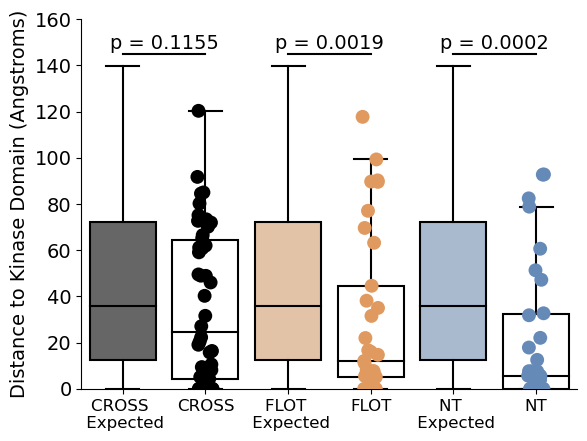

In [21]:
 fig, ax = plt.subplots()

PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}


g = sns.boxplot(data = combined, x = "label", y = "score"
                , palette = ["k", "w", "#E0995E", "w", "#668AB8", "w"], showfliers = False)
for patch in ax.patches:
    r, g1, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g1, b, 0.6))

g2 = sns.stripplot(data = combined2, x = "label", y = "score", palette=["w", "k","w", "#E0995E","w", "#668AB8"], size = 10)

x1, x2 = 0, 1  
y, h, col = 145, 0, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h+0.4, "p = 0.1155", ha='center', va='bottom', color=col, size = 14)


x1, x2 = 2, 3  
y, h, col = 145, 0, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h+0.4, "p = 0.0019", ha='center', va='bottom', color=col, size = 14)

x1, x2 = 4, 5  
y, h, col = 145, 0, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h+0.4, "p = 0.0002", ha='center', va='bottom', color=col, size = 14)

g.set_xlabel("")
g.set_xticklabels(["CROSS \n Expected", "CROSS", "FLOT \n Expected", "FLOT", "NT \n Expected", "NT"], size = 12)

g.set_ylabel("Distance to Kinase Domain (Angstroms)", size = 14)
g.set_yticklabels(g.get_yticklabels(), size = 14)
ax.set_ylim(0, 160)
sns.despine()

g.set_yticklabels([0,20,40,60,80,100,120,140,160], size = 14)

plt.savefig("ATM_distancetokinase.pdf")
plt.show()

## Mutational DDG

In [25]:
from darwinian_shift import FoldXLookup

## Define foldx data locations
fold = FoldXLookup(foldx_results_directory = "../Foldx/",
                  sifts_directory = ".",
                  download_sifts=True)

### CROSS

In [27]:
s_cross = d_cross.run_section(ATM_gene, lookup=fold, statistics = [MonteCarloTest(stat_function=np.mean, name = "MC_Mean"),
                                                                     MonteCarloTest(stat_function=np.median, name = "MC_Median"),
                                                                     CDFMonteCarloTest()])

In [28]:
s_cross.get_results_dictionary()

{'gene': 'ATM',
 'transcript_id': 'ENST00000452508',
 'chrom': '11',
 'section_id': '7SIC:A',
 'num_mutations': 50,
 'observed_median': 1.009173,
 'observed_mean': 1.3881555880000003,
 'expected_median_glob_k3': 0.917972,
 'median_shift_glob_k3': 0.09120100000000009,
 'expected_mean_glob_k3': 1.441874171208345,
 'mean_shift_glob_k3': -0.05371858320834466,
 'MC_Mean_glob_k3_observed': 1.3881555880000003,
 'MC_Mean_glob_k3_null_mean': 1.44239756600886,
 'MC_Mean_glob_k3_null_median': 1.4185213961,
 'MC_Mean_glob_k3_pvalue': 0.9305069493050695,
 'MC_Mean_glob_k3_num_smaller_or_equal': 4653,
 'MC_Mean_glob_k3_num_larger_or_equal': 5349,
 'MC_Median_glob_k3_observed': 1.009173,
 'MC_Median_glob_k3_null_mean': 0.929257222095,
 'MC_Median_glob_k3_null_median': 0.92606075,
 'MC_Median_glob_k3_pvalue': 0.7545245475452454,
 'MC_Median_glob_k3_num_smaller_or_equal': 6229,
 'MC_Median_glob_k3_num_larger_or_equal': 3773,
 'CDF_MC_glob_k3_num_smaller_or_equal': 6826,
 'CDF_MC_glob_k3_num_larger_or_e

### FLOT

In [29]:
s_flot = d_flot.run_section(ATM_gene, lookup=fold, statistics = [MonteCarloTest(stat_function=np.mean, name = "MC_Mean"),
                                                                     MonteCarloTest(stat_function=np.median, name = "MC_Median"),
                                                                     CDFMonteCarloTest()])

In [30]:
s_flot.get_results_dictionary()

{'gene': 'ATM',
 'transcript_id': 'ENST00000452508',
 'chrom': '11',
 'section_id': '7SIC:A',
 'num_mutations': 33,
 'observed_median': 0.867238,
 'observed_mean': 1.4389478757575758,
 'expected_median_glob_k3': 0.892398,
 'median_shift_glob_k3': -0.02516000000000007,
 'expected_mean_glob_k3': 1.447128326491588,
 'mean_shift_glob_k3': -0.00818045073401219,
 'MC_Mean_glob_k3_observed': 1.4389478757575758,
 'MC_Mean_glob_k3_null_mean': 1.4433446350771981,
 'MC_Mean_glob_k3_null_median': 1.4055691727272728,
 'MC_Mean_glob_k3_pvalue': 0.9335066493350664,
 'MC_Mean_glob_k3_num_smaller_or_equal': 5334,
 'MC_Mean_glob_k3_num_larger_or_equal': 4668,
 'MC_Median_glob_k3_observed': 0.867238,
 'MC_Median_glob_k3_null_mean': 0.902314119097,
 'MC_Median_glob_k3_null_median': 0.890006,
 'MC_Median_glob_k3_pvalue': 0.9505049495050495,
 'MC_Median_glob_k3_num_smaller_or_equal': 4753,
 'MC_Median_glob_k3_num_larger_or_equal': 5255,
 'CDF_MC_glob_k3_num_smaller_or_equal': 4204,
 'CDF_MC_glob_k3_num_larg

### NT

In [31]:
s_nt = d_nt.run_section(ATM_gene, lookup=fold, statistics = [MonteCarloTest(stat_function=np.mean, name = "MC_Mean"),
                                                                     MonteCarloTest(stat_function=np.median, name = "MC_Median"),
                                                                     CDFMonteCarloTest()])

In [32]:
s_nt.get_results_dictionary()

{'gene': 'ATM',
 'transcript_id': 'ENST00000452508',
 'chrom': '11',
 'section_id': '7SIC:A',
 'num_mutations': 31,
 'observed_median': 1.01199,
 'observed_mean': 1.3142544419354838,
 'expected_median_glob_k3': 0.900603,
 'median_shift_glob_k3': 0.1113869999999999,
 'expected_mean_glob_k3': 1.4481052053143126,
 'mean_shift_glob_k3': -0.13385076337882884,
 'MC_Mean_glob_k3_observed': 1.3142544419354838,
 'MC_Mean_glob_k3_null_mean': 1.4491351067645897,
 'MC_Mean_glob_k3_null_median': 1.40259595,
 'MC_Mean_glob_k3_pvalue': 0.8251174882511749,
 'MC_Mean_glob_k3_num_smaller_or_equal': 4126,
 'MC_Mean_glob_k3_num_larger_or_equal': 5876,
 'MC_Median_glob_k3_observed': 1.01199,
 'MC_Median_glob_k3_null_mean': 0.91932847072,
 'MC_Median_glob_k3_null_median': 0.896227,
 'MC_Median_glob_k3_pvalue': 0.7543245675432457,
 'MC_Median_glob_k3_num_smaller_or_equal': 6234,
 'MC_Median_glob_k3_num_larger_or_equal': 3772,
 'CDF_MC_glob_k3_num_smaller_or_equal': 7041,
 'CDF_MC_glob_k3_num_larger_or_equal'

### Plotting

In [33]:
## Same as before - we hack darwinian_shift a bit to get the plots in one place

data_cross = plot_boxplot2(s)
data_flot = plot_boxplot2(s_flot)
data_nt= plot_boxplot2(s_nt)

basedistcross = data_cross[0]
crossdist = data_cross[1]
basedistflot = data_flot[0]
flotdist = data_flot[1]
basedistnt = data_flot[0]
ntdist = data_nt[1]

basedistcross = pd.DataFrame(basedistcross)
basedistcross["label"] = "base_cross"
basedistcross.columns = ["score", "label"]

basedistflot = pd.DataFrame(basedistflot)
basedistflot["label"] = "base_flot"
basedistflot.columns = ["score", "label"]

basedistnt = pd.DataFrame(basedistnt)
basedistnt["label"] = "base_nt"
basedistnt.columns = ["score", "label"]

crossdist = pd.DataFrame(crossdist)
crossdist["label"] = "cross"

flotdist = pd.DataFrame(flotdist)
flotdist["label"] = "flot"

ntdist = pd.DataFrame(ntdist)
ntdist["label"] = "nt"

testdist_cross = pd.DataFrame([-15])
testdist_cross["label"] = "base_cross"
testdist_cross.columns = ["score", "label"]

testdist_flot = pd.DataFrame([-15])
testdist_flot["label"] = "base_flot"
testdist_flot.columns = ["score", "label"]

testdist_nt = pd.DataFrame([-15])
testdist_nt["label"] = "base_nt"
testdist_nt.columns = ["score", "label"]

combined = pd.concat([basedistcross, crossdist, basedistflot, flotdist,basedistnt, ntdist], axis =0)
combined2 = pd.concat([testdist_cross, crossdist,testdist_flot, flotdist,testdist_nt, ntdist], axis =0)

/var/folders/d9/4lyh6rdd5mdbxby_y5lwsy180000gn/T/ipykernel_97081/3941154546.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), size = 14)
/var/folders/d9/4lyh6rdd5mdbxby_y5lwsy180000gn/T/ipykernel_97081/3941154546.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels([0,-4,-2,0,2,4,6,8,10], size = 14)


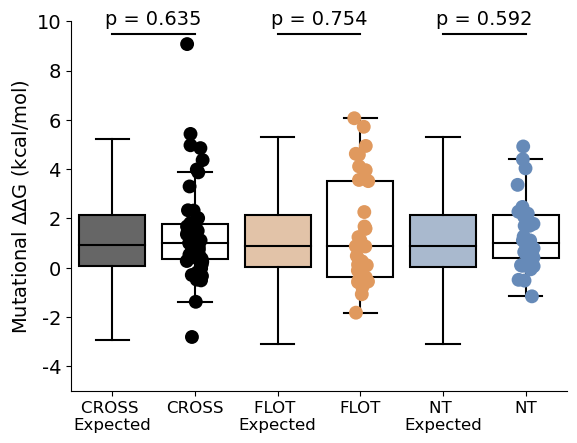

In [35]:
 fig, ax = plt.subplots()

PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}


g = sns.boxplot(data = combined, x = "label", y = "score"
                , palette = ["k", "w", "#E0995E", "w", "#668AB8", "w"], showfliers = False)
for patch in ax.patches:
    r, g1, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g1, b, 0.6))

g2 = sns.stripplot(data = combined2, x = "label", y = "score", palette=["w", "k","w", "#E0995E","w", "#668AB8"], size = 10)

x1, x2 = 0, 1  
y, h, col = 9.5, 0, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h+0.2, "p = 0.635", ha='center', va='bottom', color=col, size = 14)


x1, x2 = 2, 3  
y, h, col = 9.5, 0, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h+0.2, "p = 0.754", ha='center', va='bottom', color=col, size = 14)

x1, x2 = 4, 5  
y, h, col = 9.5, 0, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h+0.2, "p = 0.592", ha='center', va='bottom', color=col, size = 14)

g.set_xlabel("")
g.set_xticklabels(["CROSS \nExpected", "CROSS", "FLOT \nExpected", "FLOT", "NT \nExpected", "NT"], size = 12)

g.set_ylabel(r"Mutational $\Delta$$\Delta$G (kcal/mol)", size = 14)
g.set_yticklabels(g.get_yticklabels(), size = 14)

#g.set_yscale("symlog")

ax.set_ylim(-5, 10)
sns.despine()


g.set_yticklabels([0,-4,-2,0,2,4,6,8,10], size = 14)

plt.savefig("ATM_foldxDDG.pdf")
plt.show()